In [14]:
import sent2vec
cleaned_expression_data = [line.strip().split("\t") for line in open("../gold_standard_sentences/GROBID_clean_without_negative_otherexpr_with_PMIDs.csv")]
cleaned_kinaseact_data = [line.strip().split("\t") for line in open("../gold_standard_sentences/GROBID_clean_without_negative_kinaseact_with_PMIDs.csv")]
cleaned_expression_data = [[row[1], int(row[2])] for row in cleaned_expression_data]
cleaned_kinaseact_data = [[row[1], int(row[2])] for row in cleaned_kinaseact_data]
bio_sent_vec_model_location = "../biosentvec/model.bin"

In [15]:
expression_negative_data = [line.strip().split("\t") for line in open("../negative_sentences_validated/GROBID_neg_sentences_expr.tsv")]
expression_negative_data_transformed = [(row[1], 9) for row in expression_negative_data[1:] if row[2] == "Y" and (len(row) < 5 or row[4] != "Y")]

kinase_negative_data = [line.strip().split("\t") for line in open("../negative_sentences_validated/GROBID_neg_sentences_kinase.tsv")]
kinase_negative_data_transformed = [(row[1], 9) for row in kinase_negative_data[1:] if row[2] == "YES" and (len(row) < 5 or row[4] != "YES")]

expression_sentences_already_in_set = set(sentence[0] for sentence in cleaned_expression_data)
kinase_sentences_already_in_set = set(sentence[0] for sentence in cleaned_kinaseact_data)

neg_sentences_added = 0
for negative_sentence in expression_negative_data_transformed:
    if negative_sentence[0] not in expression_sentences_already_in_set:
        cleaned_expression_data.append(negative_sentence)
        expression_sentences_already_in_set.add(negative_sentence[0])
        neg_sentences_added += 1
    if neg_sentences_added == 500:
        break
        
neg_sentences_added = 0
for negative_sentence in kinase_negative_data_transformed:
    if negative_sentence[0] not in kinase_sentences_already_in_set:
        cleaned_kinaseact_data.append(negative_sentence)
        kinase_sentences_already_in_set.add(negative_sentence[0])
        neg_sentences_added += 1
    if neg_sentences_added == 500:
        break
pass

In [16]:
model_path = bio_sent_vec_model_location
biosentvec_model = sent2vec.Sent2vecModel()
try:
    biosentvec_model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [17]:
corpus_expr = biosentvec_model.embed_sentences([row[0] for row in cleaned_expression_data])
corpus_kinaseact = biosentvec_model.embed_sentences([row[0] for row in cleaned_kinaseact_data])

In [18]:
import umap

umap_reducer = umap.UMAP(metric='cosine')
corpus_expr_2d = umap_reducer.fit_transform(corpus_expr)
corpus_kinaseact_2d = umap_reducer.fit_transform(corpus_kinaseact)

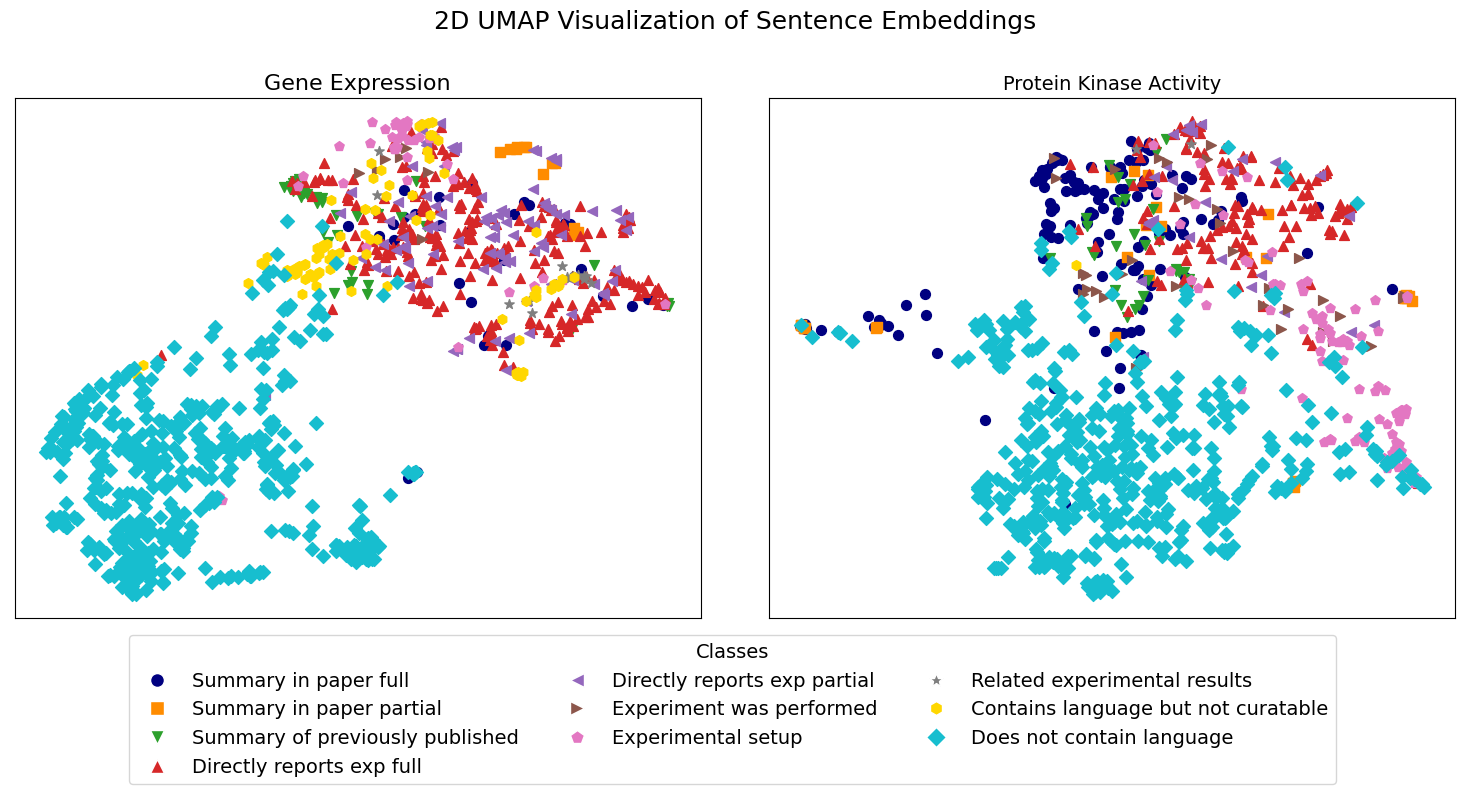

In [43]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Define colors and classes
colors = ListedColormap(['navy', 'darkorange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 'gold', 'tab:cyan'])
classes = ['Summary in paper full', 'Summary in paper partial', 'Summary of previously published', 'Directly reports exp full', 'Directly reports exp partial', 'Experiment was performed', 'Experimental setup', 'Related experimental results', 'Contains language but not curatable', 'Does not contain language']
markers = ['o', 's', 'v', '^', '<', '>', 'p', '*', 'h', 'D']

# Values for the first plot
values_expr = np.array([int(row[1]) for row in cleaned_expression_data])

# Values for the second plot
values_kinase = np.array([int(row[1]) for row in cleaned_kinaseact_data])

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Function to create a scatter plot with different markers
def scatter_with_markers(ax, x, y, values, cmap, markers):
    unique_values = np.unique(values)
    for i in unique_values:
        indices = np.where(values == i)
        ax.scatter(x[indices], y[indices], label=classes[i], color=cmap(i), marker=markers[i], s=50)

# First plot
scatter_with_markers(ax1, corpus_expr_2d[:, 0], corpus_expr_2d[:, 1], values_expr, colors, markers)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Gene Expression", fontsize=16)

# Second plot
scatter_with_markers(ax2, corpus_kinaseact_2d[:, 0], corpus_kinaseact_2d[:, 1], values_kinase, colors, markers)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Protein Kinase Activity", fontsize=14)

# Add overall title
fig.suptitle("2D UMAP Visualization of Sentence Embeddings", fontsize=18)

# Create custom legend handles
handles = [Line2D([0], [0], marker=markers[i], color='w', markerfacecolor=colors(i), markersize=10, label=classes[i]) for i in range(len(classes))]

# Add legend at the bottom with larger font size
fig.legend(handles=handles, loc='lower center', ncol=3, title="Classes", fontsize=14, title_fontsize=14)

# Adjust layout to add more space for the legend
plt.subplots_adjust(left=0.05, right=0.95, top=0.87, bottom=0.22, wspace=0.1, hspace=0.1)

plt.show()